In [8]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Load datasets
x_train = pd.read_csv('/content/drive/My Drive/ML2/X_train.csv')
x_test = pd.read_csv('/content/drive/My Drive/ML2/X_test.csv')
y_train = pd.read_csv('/content/drive/My Drive/ML2/Y_train.csv')
y_test = pd.read_csv('/content/drive/My Drive/ML2/Y_test.csv')

In [11]:
def preprocess_dataframe(df):

    columns_to_drop = ['business_id', 'name','city','state','address','categories'
                       ,'NoiseLevel','postal_code']
    # Drop the columns
    df.drop(columns=columns_to_drop, inplace=True)


    # List of columns to convert TRUE/FALSE to 1/0
    columns_to_convert = ['BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'RestaurantsTakeOut',
    'RestaurantsDelivery', 'Caters', 'WiFi', 'WheelchairAccessible',
    'OutdoorSeating', 'HasTV', 'RestaurantsReservations', 'GoodForKids',
    'RestaurantsGoodForGroups']

    for col in columns_to_convert:

    # Handle the WiFi column with specific mapping
        if 'WiFi' in df.columns:
            # Convert all values to strings
            df['WiFi'] = df['WiFi'].astype(str)

            # Clean values by removing prefixes like "u'" and surrounding quotes
            df['WiFi'] = df['WiFi'].str.replace(r"^u'|^'|'$", "", regex=True)

            # Map values to integers
            wifi_mapping = {
                '0': 0,    # Already numeric
                'no': 0,   # No WiFi
                'free': 1, # Free WiFi
                'paid': 2  # Paid WiFi
            }
            df['WiFi'] = df['WiFi'].replace(wifi_mapping)

            # Replace any remaining unexpected values or NaN with 0
            df['WiFi'] = df['WiFi'].replace({"nan": 0, np.nan: 0}).astype(int)
        if col in df.columns:
            # Replace various representations of TRUE/FALSE with 1/0
            df[col] = df[col].replace({
                "TRUE": 1, "FALSE": 0,  # String representations
                "True": 1, "False": 0,  # Other casing of strings
                True: 1, False: 0       # Boolean values
            })

            # Replace empty strings, 'nan' (as string), and NaN with 0
            df[col] = df[col].replace({"": 0, "nan": 0, np.nan: 0})

            # Explicitly cast to integer type
            df[col] = df[col].astype(int)

    # Handle the WiFi column with specific mapping
    if 'WiFi' in df.columns:
        # Convert all values to strings
        df['WiFi'] = df['WiFi'].astype(str)

        # Clean values by removing prefixes like "u'" and surrounding quotes
        df['WiFi'] = df['WiFi'].str.replace(r"^u'|^'|'$", "", regex=True)

        # Map values to integers
        wifi_mapping = {
            '0': 0,    # Already numeric
            'no': 0,   # No WiFi
            'free': 1, # Free WiFi
            'paid': 2  # Paid WiFi
        }
        df['WiFi'] = df['WiFi'].replace(wifi_mapping)

        # Replace any remaining unexpected values or NaN with 0
        df['WiFi'] = df['WiFi'].replace({"nan": 0, np.nan: 0}).astype(int)
    #df['NoiseLevel'].fillna('quiet', inplace=True)  # or any other appropriate default value
    #df['NoiseLevel'] = df['NoiseLevel'].map({'quiet': 0, 'average': 1, 'loud': 2})
    return df

x_train = preprocess_dataframe(x_train)
x_test = preprocess_dataframe(x_test)

<ipython-input-11-2371ecc0ae15>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WiFi'] = df['WiFi'].replace({"nan": 0, np.nan: 0}).astype(int)
<ipython-input-11-2371ecc0ae15>:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({
<ipython-input-11-2371ecc0ae15>:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

In [12]:
x_test.head()

,latitude,longitude,stars,review_count,is_open,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsTakeOut,RestaurantsDelivery,Caters,...,RestaurantsReservations,GoodForKids,RestaurantsGoodForGroups,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,39.938287,-74.966007,2.5,38,1,1,2,1,1,1,...,0,0,0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
1,53.602766,-113.444280,3.0,8,1,0,0,1,1,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.176512,-74.935341,3.0,6,0,1,2,1,0,0,...,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.092165,-75.031121,3.5,7,1,1,2,0,0,0,...,0,0,0,8.5,8.5,8.5,8.5,4.5,0.0,0.0
4,36.139636,-86.742698,5.0,6,1,1,0,0,0,0,...,0,0,0,0.0,8.5,8.5,8.5,8.5,0.0,0.0


In [13]:
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed

# Fit the model and predict anomalies
y_train_pred = lof.fit_predict(x_train)
y_test_pred = lof.fit_predict(x_test)

# Convert predictions to binary (0 for normal, 1 for anomaly)
y_train_anomaly = (y_train_pred == -1).astype(int)
y_test_anomaly = (y_test_pred == -1).astype(int)

# Add anomaly predictions to DataFrames for clarity
x_train['Anomaly'] = y_train_anomaly
x_test['Anomaly'] = y_test_anomaly

# Optionally, you can also include the actual target values for comparison
x_train['True_Anomaly'] = y_train
x_test['True_Anomaly'] = y_test

# Print classification report for training set
print("Training Set Classification Report:")
print(classification_report(y_train, x_train['Anomaly']))

# Print classification report for testing set
print("Testing Set Classification Report:")
print(classification_report(y_test, x_test['Anomaly']))

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.89      0.59     53088
           1       0.53      0.10      0.16     67188

    accuracy                           0.45    120276
   macro avg       0.48      0.49      0.37    120276
weighted avg       0.49      0.45      0.35    120276

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.90      0.59     13261
           1       0.55      0.10      0.17     16809

    accuracy                           0.45     30070
   macro avg       0.49      0.50      0.38     30070
weighted avg       0.50      0.45      0.35     30070



In [14]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_auc_score

# Define parameter ranges for tuning
n_neighbors_range = [5, 10, 20, 30, 50]
contamination_range = [0.05, 0.1, 0.15, 0.2]

# Store tuning results
tuning_results = []

# Initialize variables for the best model
best_params = {}
best_auc = 0
best_model = None

for n_neighbors in n_neighbors_range:
    for contamination in contamination_range:
        # Initialize the LOF model with current parameters
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)

        # Fit the model and predict anomalies for test set (LOF uses training data during fitting)
        y_test_pred = lof.fit_predict(x_test)
        y_test_anomaly = (y_test_pred == -1).astype(int)

        # Calculate ROC AUC on the test set
        auc = roc_auc_score(y_test, y_test_anomaly)

        # Save the results for the current parameters
        tuning_results.append({
            'n_neighbors': n_neighbors,
            'contamination': contamination,
            'roc_auc': auc
        })

        # Update the best model if the current model is better
        if auc > best_auc:
            best_auc = auc
            best_params = {'n_neighbors': n_neighbors, 'contamination': contamination}
            best_model = lof

# Convert tuning results to a DataFrame for better readability
results_df = pd.DataFrame(tuning_results)

# Display all tuning results
print("Tuning Results:")
print(results_df.sort_values(by='roc_auc', ascending=False))

# Use the best model for final predictions
y_test_pred_best = best_model.fit_predict(x_test)
x_test['Anomaly'] = (y_test_pred_best == -1).astype(int)

# Print classification report for the best model on the test set
print("\nBest Model Test Set Classification Report:")
print(classification_report(y_test, x_test['Anomaly']))

# Output best parameters
print(f"\nBest Parameters: {best_params}")
print(f"Best ROC AUC: {best_auc}")


Tuning Results:
    n_neighbors  contamination   roc_auc
19           50           0.20  0.498664
18           50           0.15  0.496652
9            20           0.10  0.496634
12           30           0.05  0.496443
8            20           0.05  0.496443
15           30           0.20  0.496371
4            10           0.05  0.496308
5            10           0.10  0.496297
11           20           0.20  0.496101
10           20           0.15  0.495101
16           50           0.05  0.495027
6            10           0.15  0.494966
7            10           0.20  0.494752
0             5           0.05  0.494690
14           30           0.15  0.494359
17           50           0.10  0.494071
13           30           0.10  0.493801
1             5           0.10  0.493531
3             5           0.20  0.492324
2             5           0.15  0.492066

Best Model Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.44 


==== Tuning Round 1 ====



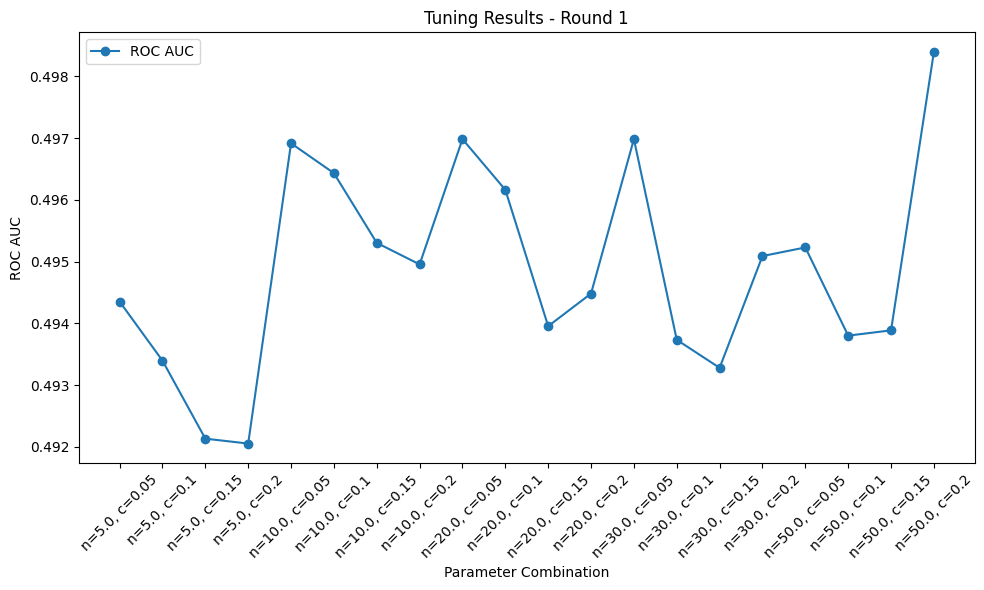

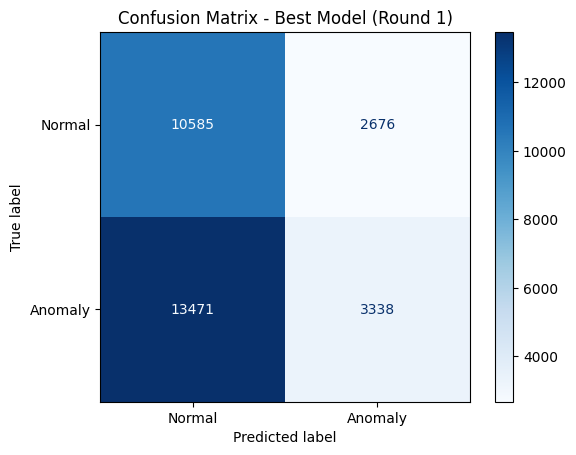

Tuning Results for Round 1:

    n_neighbors  contamination   roc_auc
19           50           0.20  0.498395
8            20           0.05  0.496983
12           30           0.05  0.496983
4            10           0.05  0.496916
5            10           0.10  0.496432
9            20           0.10  0.496162
6            10           0.15  0.495303
16           50           0.05  0.495229
15           30           0.20  0.495090
7            10           0.20  0.494955
11           20           0.20  0.494483
0             5           0.05  0.494352
10           20           0.15  0.493954
18           50           0.15  0.493887
17           50           0.10  0.493801
13           30           0.10  0.493734
1             5           0.10  0.493397
14           30           0.15  0.493280
2             5           0.15  0.492133
3             5           0.20  0.492054

Best Parameters for Round 1: {'n_neighbors': 50, 'contamination': 0.2}
Best ROC AUC for Round 1: 0.4983946777

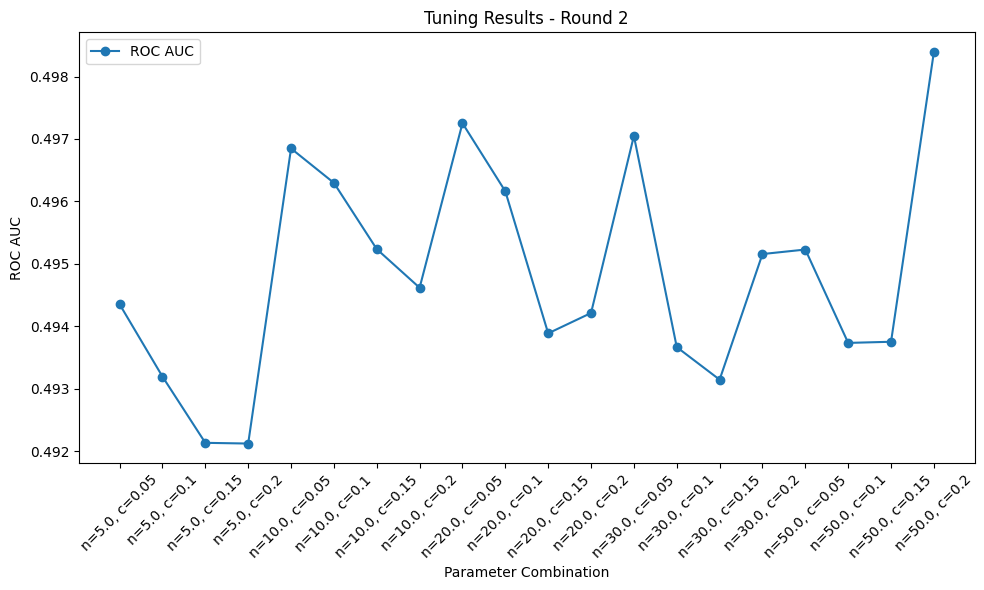

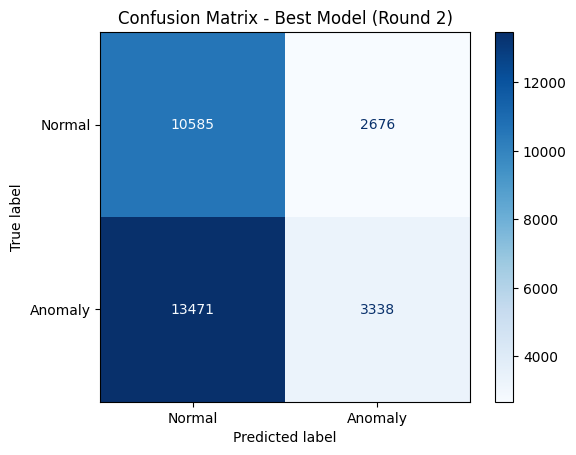

Tuning Results for Round 2:

    n_neighbors  contamination   roc_auc
19           50           0.20  0.498395
8            20           0.05  0.497253
12           30           0.05  0.497050
4            10           0.05  0.496848
5            10           0.10  0.496297
9            20           0.10  0.496162
6            10           0.15  0.495236
16           50           0.05  0.495229
15           30           0.20  0.495157
7            10           0.20  0.494617
0             5           0.05  0.494352
11           20           0.20  0.494213
10           20           0.15  0.493887
18           50           0.15  0.493752
17           50           0.10  0.493734
13           30           0.10  0.493666
1             5           0.10  0.493194
14           30           0.15  0.493145
2             5           0.15  0.492133
3             5           0.20  0.492122

Best Parameters for Round 2: {'n_neighbors': 50, 'contamination': 0.2}
Best ROC AUC for Round 2: 0.4983946777

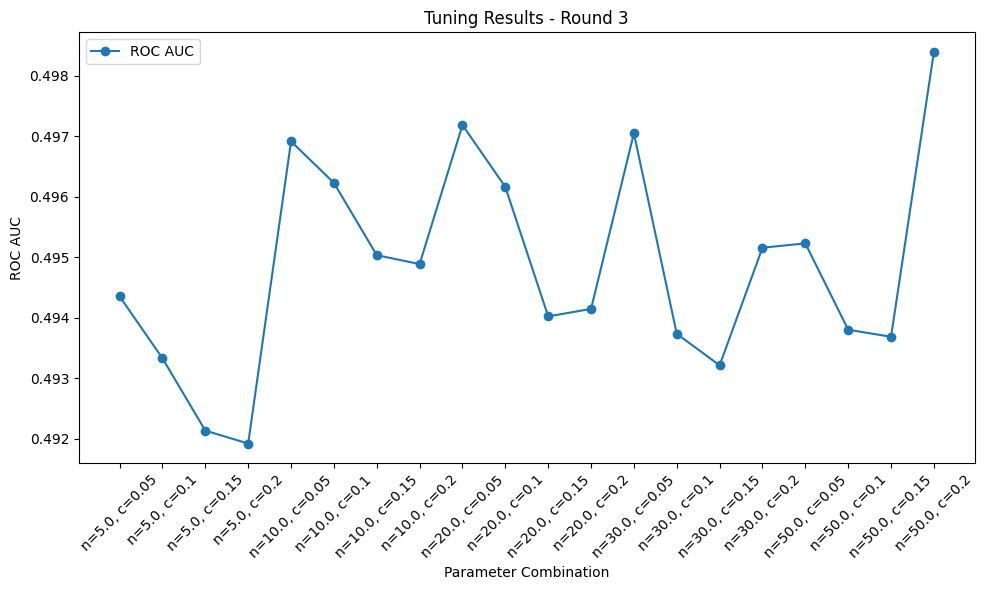

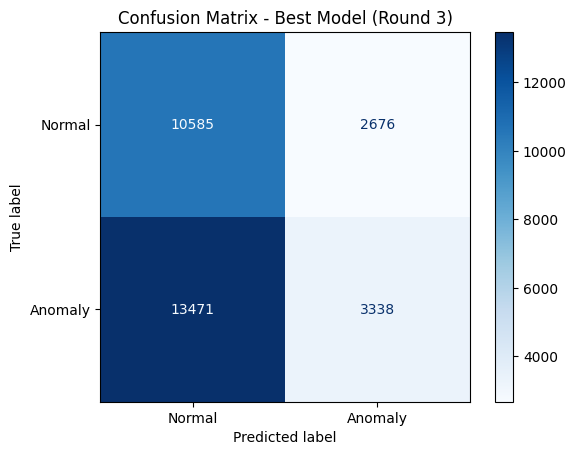

Tuning Results for Round 3:

    n_neighbors  contamination   roc_auc
19           50           0.20  0.498395
8            20           0.05  0.497185
12           30           0.05  0.497050
4            10           0.05  0.496916
5            10           0.10  0.496230
9            20           0.10  0.496162
16           50           0.05  0.495229
15           30           0.20  0.495157
6            10           0.15  0.495034
7            10           0.20  0.494887
0             5           0.05  0.494352
11           20           0.20  0.494145
10           20           0.15  0.494022
17           50           0.10  0.493801
13           30           0.10  0.493734
18           50           0.15  0.493685
1             5           0.10  0.493329
14           30           0.15  0.493212
2             5           0.15  0.492133
3             5           0.20  0.491919

Best Parameters for Round 3: {'n_neighbors': 50, 'contamination': 0.2}
Best ROC AUC for Round 3: 0.4983946777

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define parameter ranges for tuning
n_neighbors_range = [5, 10, 20, 30, 50]
contamination_range = [0.05, 0.1, 0.15, 0.2]

# Function to perform a single round of tuning
def tune_lof(x_train, x_test, y_test, round_number):
    tuning_results = []
    best_params = {}
    best_auc = 0
    best_model = None

    for n_neighbors in n_neighbors_range:
        for contamination in contamination_range:
            # Initialize the LOF model with current parameters
            lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)

            # Fit the model and predict anomalies for test set
            y_test_pred = lof.fit_predict(x_test)
            y_test_anomaly = (y_test_pred == -1).astype(int)

            # Calculate ROC AUC on the test set
            auc = roc_auc_score(y_test, y_test_anomaly)

            # Save the results for the current parameters
            tuning_results.append({
                'n_neighbors': n_neighbors,
                'contamination': contamination,
                'roc_auc': auc
            })

            # Update the best model if the current model is better
            if auc > best_auc:
                best_auc = auc
                best_params = {'n_neighbors': n_neighbors, 'contamination': contamination}
                best_model = lof

    # Convert tuning results to a DataFrame
    results_df = pd.DataFrame(tuning_results)

    # Plot ROC AUC for all parameter combinations
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(results_df)), results_df['roc_auc'], marker='o', label='ROC AUC')
    plt.xticks(range(len(results_df)),
               [f"n={row['n_neighbors']}, c={row['contamination']}" for _, row in results_df.iterrows()], rotation=45)
    plt.xlabel("Parameter Combination")
    plt.ylabel("ROC AUC")
    plt.title(f"Tuning Results - Round {round_number}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Use the best model for final predictions
    y_test_pred_best = best_model.fit_predict(x_test)
    x_test['Anomaly'] = (y_test_pred_best == -1).astype(int)

    # Confusion matrix for the best model
    cm = confusion_matrix(y_test, x_test['Anomaly'])
    ConfusionMatrixDisplay(cm, display_labels=["Normal", "Anomaly"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Best Model (Round {round_number})")
    plt.show()

    # Return results
    return results_df, best_params, best_auc

# Perform 3 rounds of tuning
all_results = {}
for round_num in range(1, 4):
    print(f"\n==== Tuning Round {round_num} ====\n")
    results_df, best_params, best_auc = tune_lof(x_train, x_test, y_test, round_num)
    all_results[f"Round {round_num}"] = {
        "results": results_df,
        "best_params": best_params,
        "best_auc": best_auc
    }
    print(f"Tuning Results for Round {round_num}:\n")
    print(results_df.sort_values(by='roc_auc', ascending=False))
    print(f"\nBest Parameters for Round {round_num}: {best_params}")
    print(f"Best ROC AUC for Round {round_num}: {best_auc}\n")

# Display summary of all rounds
print("\n=== Summary of All Rounds ===\n")
for round_num, data in all_results.items():
    print(f"{round_num}: Best Parameters = {data['best_params']}, Best ROC AUC = {data['best_auc']}")



==== Tuning Round 1 ====



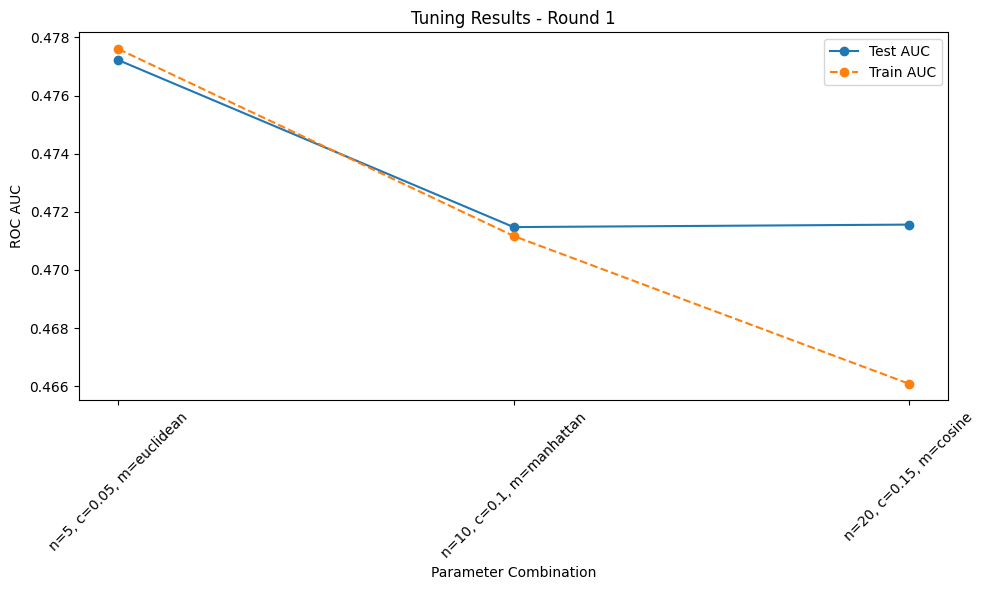

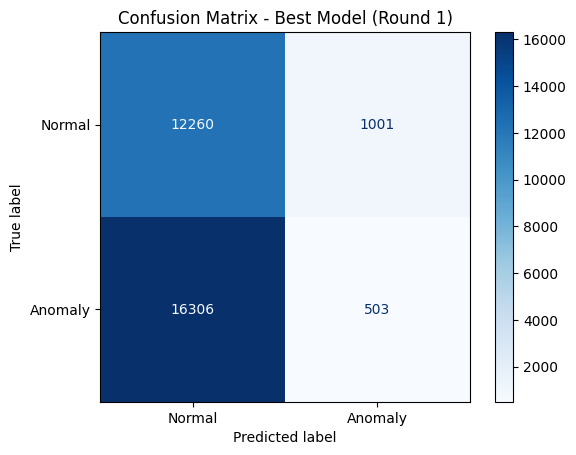

Tuning Results for Round 1:

   n_neighbors  contamination     metric  train_auc  test_auc
0            5           0.05  euclidean   0.477601  0.477220
2           20           0.15     cosine   0.466085  0.471561
1           10           0.10  manhattan   0.471169  0.471475

Best Parameters for Round 1: {'n_neighbors': 5, 'contamination': 0.05, 'metric': 'euclidean'}
Best Test ROC AUC for Round 1: 0.4772199709032783


==== Tuning Round 2 ====



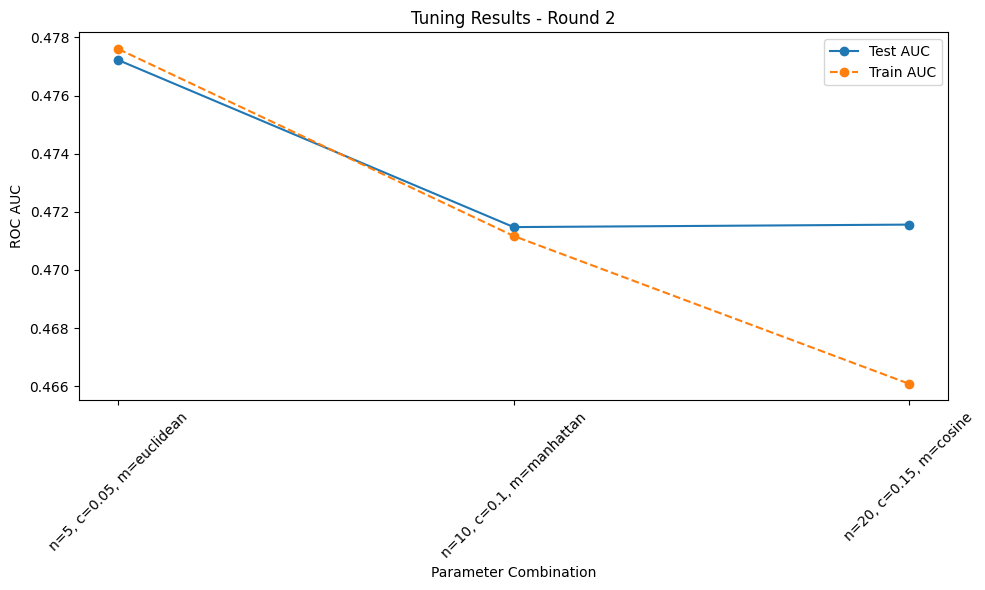

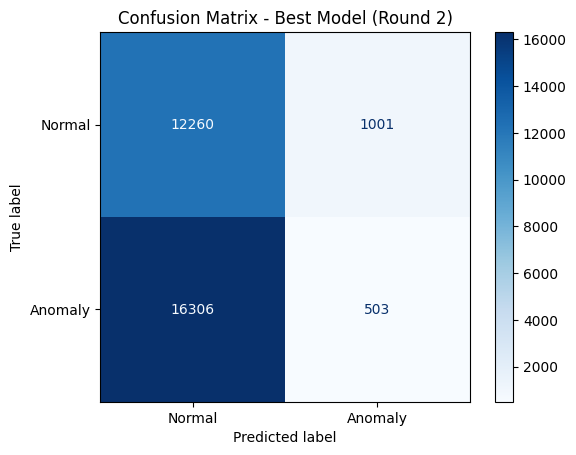

Tuning Results for Round 2:

   n_neighbors  contamination     metric  train_auc  test_auc
0            5           0.05  euclidean   0.477601  0.477220
2           20           0.15     cosine   0.466085  0.471561
1           10           0.10  manhattan   0.471169  0.471475

Best Parameters for Round 2: {'n_neighbors': 5, 'contamination': 0.05, 'metric': 'euclidean'}
Best Test ROC AUC for Round 2: 0.4772199709032783


==== Tuning Round 3 ====



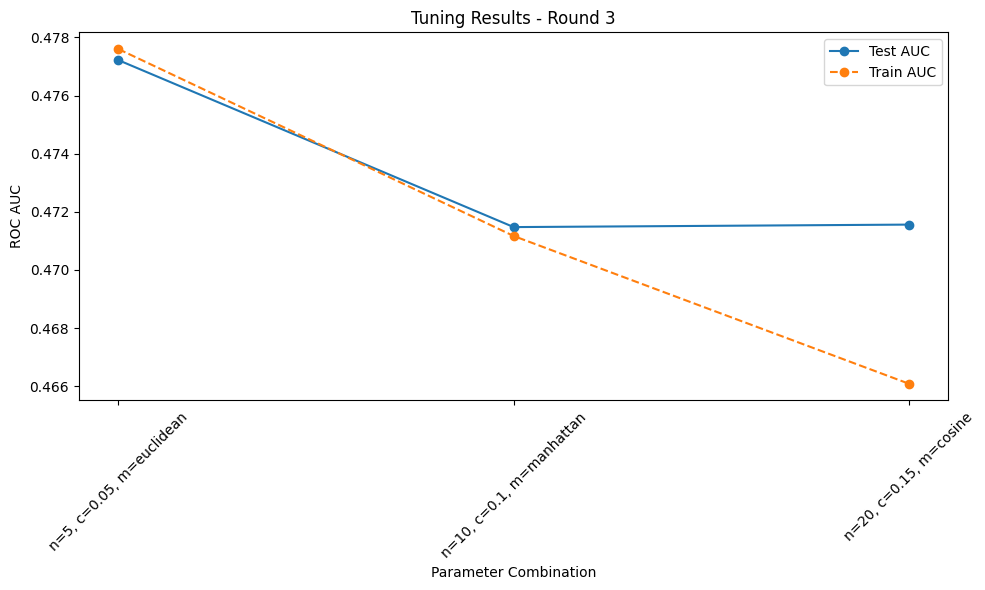

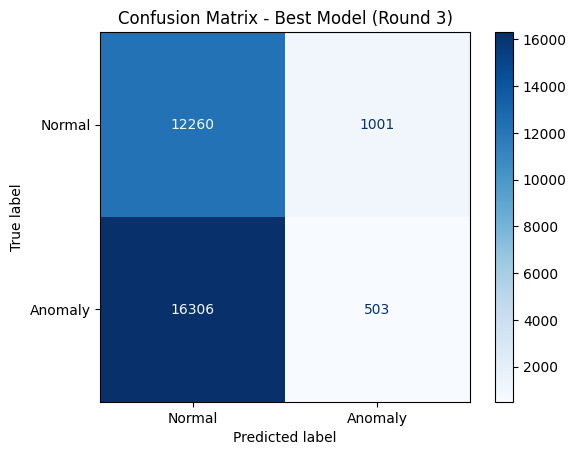

Tuning Results for Round 3:

   n_neighbors  contamination     metric  train_auc  test_auc
0            5           0.05  euclidean   0.477601  0.477220
2           20           0.15     cosine   0.466085  0.471561
1           10           0.10  manhattan   0.471169  0.471475

Best Parameters for Round 3: {'n_neighbors': 5, 'contamination': 0.05, 'metric': 'euclidean'}
Best Test ROC AUC for Round 3: 0.4772199709032783


=== Summary of All Rounds ===

Round 1: Best Parameters = {'n_neighbors': 5, 'contamination': 0.05, 'metric': 'euclidean'}, Best Test ROC AUC = 0.4772199709032783
Round 2: Best Parameters = {'n_neighbors': 5, 'contamination': 0.05, 'metric': 'euclidean'}, Best Test ROC AUC = 0.4772199709032783
Round 3: Best Parameters = {'n_neighbors': 5, 'contamination': 0.05, 'metric': 'euclidean'}, Best Test ROC AUC = 0.4772199709032783


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Parameter ranges
n_neighbors_range = [5, 10, 20, 30, 50]
contamination_range = [0.05, 0.1, 0.15, 0.2]
metrics = ['euclidean', 'manhattan', 'cosine']

# Function to perform tuning
def tune_lof(x_train_scaled, x_test_scaled, y_train, y_test, round_number):
    tuning_results = []
    best_params = {}
    best_auc = 0
    best_model = None

    '''for n_neighbors in n_neighbors_range:
        for contamination in contamination_range:
            for metric in metrics:'''
    for i in range(3):
        # Initialize LOF with current parameters
                lof = LocalOutlierFactor(n_neighbors=n_neighbors_range[i], contamination=contamination_range[i], metric=metrics[i])

                # Fit the model and predict anomalies for train and test sets
                y_train_pred = lof.fit_predict(x_train_scaled)
                y_test_pred = lof.fit_predict(x_test_scaled)

                # Convert predictions to binary (0 for normal, 1 for anomaly)
                y_train_anomaly = (y_train_pred == -1).astype(int)
                y_test_anomaly = (y_test_pred == -1).astype(int)

                # Calculate ROC AUC for train and test sets
                train_auc = roc_auc_score(y_train, y_train_anomaly)
                test_auc = roc_auc_score(y_test, y_test_anomaly)

                # Save results for the current parameters
                tuning_results.append({
                    'n_neighbors': n_neighbors_range[i],
                    'contamination': contamination_range[i],
                    'metric': metrics[i],
                    'train_auc': train_auc,
                    'test_auc': test_auc
                })

                # Update the best model if the current model is better
                if test_auc > best_auc:
                    best_auc = test_auc
                    best_params = {'n_neighbors': n_neighbors_range[i], 'contamination': contamination_range[i], 'metric': metrics[i]}
                    best_model = lof

    # Convert results to DataFrame
    results_df = pd.DataFrame(tuning_results)

    # Plot Train vs. Test AUC
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['test_auc'], marker='o', label='Test AUC')
    plt.plot(results_df['train_auc'], marker='o', linestyle='--', label='Train AUC')
    plt.xlabel("Parameter Combination")
    plt.ylabel("ROC AUC")
    plt.title(f"Tuning Results - Round {round_number}")
    plt.legend()
    plt.xticks(range(len(results_df)),
               [f"n={row['n_neighbors']}, c={row['contamination']}, m={row['metric']}"
                for _, row in results_df.iterrows()], rotation=45)
    plt.tight_layout()
    plt.show()

    # Use the best model for final predictions
    y_test_pred_best = best_model.fit_predict(x_test_scaled)
    x_test['Anomaly'] = (y_test_pred_best == -1).astype(int)

    # Confusion matrix for the best model
    cm = confusion_matrix(y_test, x_test['Anomaly'])
    ConfusionMatrixDisplay(cm, display_labels=["Normal", "Anomaly"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Best Model (Round {round_number})")
    plt.show()

    # Return results
    return results_df, best_params, best_auc

# Perform 3 rounds of tuning
all_results = {}
for round_num in range(1, 4):
    print(f"\n==== Tuning Round {round_num} ====\n")
    results_df, best_params, best_auc = tune_lof(x_train_scaled, x_test_scaled, y_train, y_test, round_num)
    all_results[f"Round {round_num}"] = {
        "results": results_df,
        "best_params": best_params,
        "best_auc": best_auc
    }
    print(f"Tuning Results for Round {round_num}:\n")
    print(results_df.sort_values(by='test_auc', ascending=False))
    print(f"\nBest Parameters for Round {round_num}: {best_params}")
    print(f"Best Test ROC AUC for Round {round_num}: {best_auc}\n")

# Display summary of all rounds
print("\n=== Summary of All Rounds ===\n")
for round_num, data in all_results.items():
    print(f"{round_num}: Best Parameters = {data['best_params']}, Best Test ROC AUC = {data['best_auc']}")


In [17]:

# Integrate LIME for interpreting the best models
for round_num, data in all_results.items():
    print(f"\n=== LIME Interpretation for {round_num} ===\n")
    # The 'model' key was not stored, access the best_model directly from data instead
    best_model = data['best_model'] if 'best_model' in data else None
    # Handle the case where best_model is None (e.g., if an earlier cell failed)
    if best_model is None:
        print(f"No best model found for {round_num}, skipping LIME interpretation.")
        continue # Skip to the next round
    # Prepare data for LIME
    explainer = lime.lime_tabular.LimeTabularExplainer(x_train_scaled,
                                                       feature_names=x_train.columns.tolist(),
                                                       class_names=["Normal", "Anomaly"],
                                                       mode='classification')
    # Select a random sample from the test set for LIME explanation
    idx = np.random.choice(x_test.index, size=1)[0]
    exp = explainer.explain_instance(x_test_scaled[idx], best_model.predict_proba)
    # Show the LIME explanation
    exp.show_in_notebook()


=== LIME Interpretation for Round 1 ===

No best model found for Round 1, skipping LIME interpretation.

=== LIME Interpretation for Round 2 ===

No best model found for Round 2, skipping LIME interpretation.

=== LIME Interpretation for Round 3 ===

No best model found for Round 3, skipping LIME interpretation.


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import joblib

In [19]:
joblib.dump(best_model, 'lof_model.pkl')

['lof_model.pkl']

# HTML Generation

In [ ]:
from nbconvert import HTMLExporter
import nbformat

In [ ]:
# Path to your Jupyter Notebook file
input_file = 'dbscan_model.ipynb'
output_file = 'dbscan_model.html'

In [ ]:
# Read the notebook
with open(input_file, 'r', encoding='utf-8') as file:
    notebook = nbformat.read(file, as_version=4)

# Export the notebook to HTML
html_exporter = HTMLExporter()
html_data, _ = html_exporter.from_notebook_node(notebook)

# Write the HTML data to a file
with open(output_file, 'w', encoding='utf-8') as file:
    file.write(html_data)

print(f"Notebook converted to HTML and saved as {output_file}")

Notebook converted to HTML and saved as dbscan_model.html
